# Automated doubly robust estimation with ChiRho

## Outline

- [Setup](#setup)

- [Overview: Systematically adjusting for observed confounding](#overview:-systematically-adjusting-for-observed-confounding)
    - [Task: Treatment effect estimation with observational data](#task:-treatment-effect-estimation-with-observational-data)
    - [Challenge: Confounding](#challenge:-confounding)
    - [Assumptions: All confounders observed](#assumptions:-all-confounders-observed)
    - [Intuition: Statistically adjusting for confounding](#intuition:-statistically-adjusting-for-confounding)

- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model description](#model-description)
    - [Generating data](#generating-data)
    - [Fit parameters via maximum likelihood](#fit-parameters-via-maximum-likelihood)

- [Causal Query: average treatment effect (ATE)](#causal-query:-average-treatment-effect-\(ATE\))
    - [Defining the target functional](#defining-the-target-functional)
    - [Closed form doubly robust correction](#closed-form-doubly-robust-correction)
    - [Computing automated doubly robust estimators via Monte Carlo](#computing-automated-doubly-robust-estimators-via-monte-carlo)
    - [Results](#results)

- [References](#references)

## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
from typing import Callable, Optional, Tuple

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import pyro.contrib.gp as gp

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.robust.internals.utils import ParamDict
from chirho.robust.handlers.estimators import one_step_corrected_estimator, tmle
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood


pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

[2024-01-26 00:49:14,946] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


## Overview

In this tutorial, we will use ChiRho to estimate the average treatment effect (ATE) from observational data. We will use a simple example to illustrate the basic concepts of doubly robust estimation and how ChiRho can be used to automate the process for more general summaries of interest. 

There are five main steps to our doubly robust estimation procedure but only the last step is different from a standard probabilistic programming workflow:
1. Write model of interest
    - Define probabilistic model of interest using Pyro
2. Feed in data
    - Observed data used to train the model
3. Run inference
    - Use Pyro's rich inference library to fit the model to the data
4. Define target functional
    - This is the model summary of interest (e.g. average treatment effect)
5. Compute robust estimate
    - Use ChiRho to compute the doubly robust estimate of the target functional
    - Importantly, this step is automated and does not require refitting the model for each new functional

## Causal Probabilistic Program

### Model Description
In this example, we will focus on a cannonical model `CausalGLM` consisting of three types of variables: binary treatment (`A`), confounders (`X`), and response (`Y`). For simplicitly, we assume that the response is generated from a generalized linear model with link function $g$. The model is described by the following generative process:

$$
\begin{align*}
X &\sim \text{Normal}(0, I_p) \\
A &\sim \text{Bernoulli}(\pi(X)) \\
\mu &= \beta_0 + \beta_1^T X + \tau A \\
Y &\sim \text{ExponentialFamily}(\text{mean} = g^{-1}(\mu))
\end{align*}
$$

where $p$ denotes the number of confounders, $\pi(X)$ is the probability of treatment conditional on confounders $X$, $\beta_0$ is the intercept, $\beta_1$ is the confounder effect, and $\tau$ is the treatment effect.

In [2]:
class CausalGLM(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
        A = pyro.sample(
            "A",
            dist.Bernoulli(
                logits=torch.einsum("...i,...i->...", X, propensity_weights)
            ),
        )

        return pyro.sample(
            "Y",
            self.link_fn(
                torch.einsum("...i,...i->...", X, outcome_weights) + A * tau + intercept
            ),
        )

Next, we will condition on both treatment and confounders to estimate the causal effect of treatment on the outcome. We will use the following causal probabilistic program to do so:

In [3]:
class ConditionedCausalGLM(CausalGLM):
    def __init__(
        self,
        X: torch.Tensor,
        A: torch.Tensor,
        Y: torch.Tensor,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        p = X.shape[1]
        super().__init__(p, link_fn, prior_scale)
        self.X = X
        self.A = A
        self.Y = Y

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        with pyro.plate("__train__", size=self.X.shape[0], dim=-1):
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1), obs=self.X)
            A = pyro.sample(
                "A",
                dist.Bernoulli(
                    logits=torch.einsum("ni,i->n", self.X, propensity_weights)
                ),
                obs=self.A,
            )
            pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("ni,i->n", X, outcome_weights)
                    + A * tau
                    + intercept
                ),
                obs=self.Y,
            )

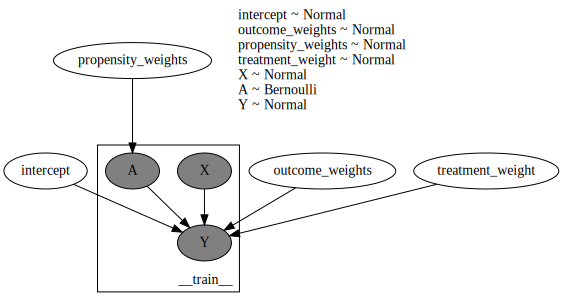

In [4]:
# Visualize the model
pyro.render_model(
    ConditionedCausalGLM(torch.zeros(1, 1), torch.zeros(1), torch.zeros(1)),
    render_params=True, 
    render_distributions=True
)

### Generating data

For evaluation, we generate `N_datasets` datasets, each with `N` samples. We compare vanilla estimates of the target functional with the double robust estimates of the target functional across the `N_sims` datasets. We use a similar data generating process as in Kennedy (2022).

In [5]:
class GroundTruthModel(CausalGLM):
    def __init__(
        self,
        p: int,
        alpha: int,
        beta: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        treatment_weight: float = 0.0,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparsity of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_intercept(self):
        return torch.tensor(0.0)

In [6]:
N_datasets = 10
simulated_datasets = []

# Data configuration
p = 2
alpha = 50
beta = 50
N_train = 500
N_test = 500

true_model = GroundTruthModel(p, alpha, beta)

for _ in range(N_datasets):
    # Generate data
    D_train = Predictive(
        true_model, num_samples=N_train, return_sites=["X", "A", "Y"]
    )()
    D_test = Predictive(
        true_model, num_samples=N_test, return_sites=["X", "A", "Y"]
    )()
    simulated_datasets.append((D_train, D_test))

### Fit parameters via maximum likelihood

In [7]:
fitted_params = []
for i in range(N_datasets):
    # Generate data
    D_train = simulated_datasets[i][0]

    # Fit model using maximum likelihood
    conditioned_model = ConditionedCausalGLM(
        X=D_train["X"], A=D_train["A"], Y=D_train["Y"]
    )
    
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo()
    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for _ in range(2000):
        adam.zero_grad()
        loss = elbo()
        loss.backward()
        adam.step()

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
    }
    fitted_params.append(theta_hat)

## Causal Query: Average treatment effect (ATE)

The average treatment effect summarizes, on average, how much the treatment changes the response, $ATE = \mathbb{E}[Y|do(A=1)] - \mathbb{E}[Y|do(A=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $A$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $A$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.


To implement this query in ChiRho, we define the `ATEFunctional` class which take in a `model` and `guide` and returns the average treatment effect by simulating from the posterior predictive distribution of the model and guide.

### Defining the target functional

In [8]:
class ATEFunctional(torch.nn.Module):
    def __init__(self, model: Callable, *, num_monte_carlo: int = 100):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
    
    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(A=(torch.tensor(0.0), torch.tensor(1.0)))):
                    Ys = self.model(*args, **kwargs)
                Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
                Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
        ate = (Y1 - Y0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)

### Closed form doubly robust correction

For the average treatment effect functional, there exists a closed-form analytical formula for the doubly robust correction. This formula is derived in Kennedy (2022) and is implemented below:

In [10]:
from typing import Any
from chirho.robust.ops import Functional, Point, P, S, T

def ate_causal_glm_analytic_influence(
    functional: Functional[P, S], 
    point: Point[T], 
    pointwise_influence: bool = True,
    **kwargs
) -> Functional[P, S]:
    def _ate_influence_functional(model: Callable[P, Any]) -> Callable[P, S]:
        assert isinstance(model.model, CausalGLM)
        theta = dict(model.guide.named_parameters())
        def correction(*args, **kwargs):
            X = point["X"]
            A = point["A"]
            Y = point["Y"]
            
            pi_X = torch.sigmoid(torch.einsum("...i,...i->...", X, theta["propensity_weights_param"]))
            mu_X = (
                torch.einsum("...i,...i->...", X, theta["outcome_weights_param"])
                + A * theta["treatment_weight_param"]
                + theta["intercept_param"]
            )
            analytic_eif_at_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
            if pointwise_influence:
                return analytic_eif_at_pts
            else:
                return analytic_eif_at_pts.mean()
        return correction
    
    return _ate_influence_functional

### Computing automated doubly robust estimators via Monte Carlo

While the doubly robust correction term is known in closed-form for the average treatment effect functional, our `one_step_correction` and `tmle` function in `ChiRho` works for a wide class of other functionals. We focus on the average treatment effect functional here so that we have a ground truth to compare `one_step_correction` and `tmle` against. We also compare against DoubleML estimator.

In [11]:
# Helper class to create a trivial guide that returns the maximum likelihood estimate
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )

In [12]:
# Compute doubly robust ATE estimates using both the automated and closed form expressions

import tracemalloc
tracemalloc.start()

# Estimators to compare
estimators = {"tmle": tmle, "one_step": one_step_corrected_estimator, "double_ml": None} # We'll do DoubleML in the loop
estimator_kwargs = {
    "tmle": {
        "learning_rate": 5e-5,
        "n_grad_steps": 500,
        "n_tmle_steps": 1,
        "num_nmc_samples": 1, # Since we're using point estimate
        "num_grad_samples": N_test
    }, 
    "one_step": {}
}

# Influence functions
influences = {"analytic_eif": ate_causal_glm_analytic_influence, "monte_carlo_eif": influence_fn}

# Cache the results
estimates = {f"{influence}-{estimator}": torch.zeros(N_datasets) for influence in influences.keys() for estimator in estimators.keys()}
estimates["plug-in-mle-from-model"] = torch.zeros(N_datasets)
estimates["plug-in-mle-from-test"] = torch.zeros(N_datasets)

# ATE functional of interest
functional = functools.partial(ATEFunctional, num_monte_carlo=10000)

for i in range(N_datasets):
    D_test = simulated_datasets[i][1]
    theta_hat = fitted_params[i]
    # Weird memory leak issue hack fix
    theta_hat = {
            k: v.clone().detach().requires_grad_(True) for k, v in theta_hat.items()
    }
    mle_guide = MLEGuide(theta_hat)
    model = PredictiveModel(CausalGLM(p), mle_guide)
    
    print("plug-in-mle-from-model", i)
    estimates["plug-in-mle-from-model"][i] = functional(model)().detach().item()

    mu_X = (
        torch.einsum("...i,...i->...", D_test["X"], theta_hat["outcome_weights"])
        + D_test["A"] * theta_hat["treatment_weight"]
        + theta_hat["intercept"]
    )
    
    mu_X_treat = mu_X[D_test["A"] == 1]
    mu_X_control = mu_X[D_test["A"] == 0]
    
    # Used for DoubleML later on
    estimates["plug-in-mle-from-test"] = (mu_X_treat.mean() - mu_X_control.mean()).detach().item()

    for estimator_str, estimator in estimators.items():
        if estimator_str != 'double_ml':
            for influence_str, influence in influences.items():
                print(estimator_str, influence_str, i)
                
                estimate = estimator(
                    functional, 
                    D_test,
                    num_samples_outer=max(10000, 100 * p), 
                    num_samples_inner=1,
                    influence_estimator=influence,
                    **estimator_kwargs[estimator_str]
                )(model)()

                estimates[f"{influence_str}-{estimator_str}"][i] = estimate.detach().item()
    
    # Compute DoubleML estimate (see Proposition in our paper for this trick to reduce one step to DoubleML)
    if 'one_step' in estimators.keys():
        for influence_str, influence in influences.items():
            eif_correction = estimates[f"{influence_str}-one_step"][i] - estimates["plug-in-mle-from-model"][i]
            double_ml = estimates["plug-in-mle-from-test"] + eif_correction
            estimates[f"{influence_str}-double_ml"][i] = double_ml.item()
    
    # Check memory usage
    print(torch.cuda.memory_allocated() / 1e9)
    print(tracemalloc.get_traced_memory())
    del theta_hat # Free up memory (weird memory leak issue)
    
    

plug-in-mle-from-model 0
tmle analytic_eif 0
tmle monte_carlo_eif 0
one_step analytic_eif 0
one_step monte_carlo_eif 0
0.0
(1936348, 13798027)
plug-in-mle-from-model 1
tmle analytic_eif 1
tmle monte_carlo_eif 1
one_step analytic_eif 1
one_step monte_carlo_eif 1
0.0
(2033412, 13798027)
plug-in-mle-from-model 2
tmle analytic_eif 2
tmle monte_carlo_eif 2
one_step analytic_eif 2
one_step monte_carlo_eif 2
0.0
(2079867, 13798027)
plug-in-mle-from-model 3
tmle analytic_eif 3
tmle monte_carlo_eif 3
one_step analytic_eif 3
one_step monte_carlo_eif 3
0.0
(2095378, 13798027)
plug-in-mle-from-model 4
tmle analytic_eif 4
tmle monte_carlo_eif 4
one_step analytic_eif 4
one_step monte_carlo_eif 4
0.0
(2111200, 13798027)
plug-in-mle-from-model 5
tmle analytic_eif 5
tmle monte_carlo_eif 5
one_step analytic_eif 5
one_step monte_carlo_eif 5
0.0
(2125888, 13798027)
plug-in-mle-from-model 6
tmle analytic_eif 6
tmle monte_carlo_eif 6
one_step analytic_eif 6
one_step monte_carlo_eif 6
0.0
(2143966, 13798027)

In [18]:
# The true treatment effect is 0, so a mean estimate closer to zero is better
results = pd.DataFrame(estimates)
results.describe().round(2)

,analytic_eif-tmle,analytic_eif-one_step,analytic_eif-double_ml,monte_carlo_eif-tmle,monte_carlo_eif-one_step,monte_carlo_eif-double_ml,plug-in-mle-from-model,plug-in-mle-from-test
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,0.02,0.01,0.06,0.01,0.01,0.05,0.01,-0.08
std,0.06,0.11,0.13,0.06,0.09,0.11,0.08,0.00
min,-0.08,-0.15,-0.13,-0.08,-0.12,-0.11,-0.10,-0.08
25%,-0.03,-0.07,-0.04,-0.04,-0.08,-0.03,-0.07,-0.08
50%,0.03,0.01,0.03,0.02,0.01,0.04,0.04,-0.08
75%,0.06,0.09,0.16,0.06,0.06,0.14,0.07,-0.08
max,0.10,0.21,0.26,0.10,0.16,0.21,0.11,-0.08


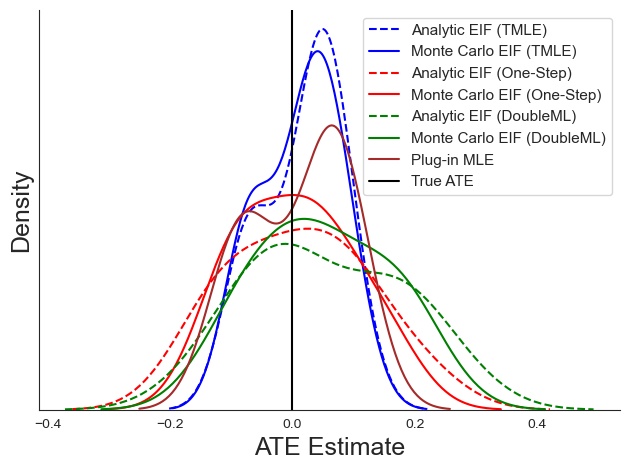

In [52]:
# Visualize the results
fig, ax = plt.subplots()

# TMLE
sns.kdeplot(
    estimates['analytic_eif-tmle'], 
    label="Analytic EIF (TMLE)",
    ax=ax,
    color='blue',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-tmle'], 
    label="Monte Carlo EIF (TMLE)",
    ax=ax,
    color='blue'
)

# One-step
sns.kdeplot(
    estimates['analytic_eif-one_step'], 
    label="Analytic EIF (One-Step)",
    ax=ax,
    color='red',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-one_step'], 
    label="Monte Carlo EIF (One-Step)",
    ax=ax,
    color='red'
)

# DoubleML
sns.kdeplot(
    estimates['analytic_eif-double_ml'], 
    label="Analytic EIF (DoubleML)",
    ax=ax,
    color='green',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-double_ml'], 
    label="Monte Carlo EIF (DoubleML)",
    ax=ax,
    color='green'
)

# Plug-in MLE
sns.kdeplot(
    estimates['plug-in-mle-from-model'], 
    label="Plug-in MLE",
    ax=ax,
    color='brown'
)

ax.axvline(0, color="black", label="True ATE", linestyle="solid")
ax.set_yticks([])
sns.despine()
ax.set_xlabel("ATE Estimate", fontsize=18)
ax.set_ylabel("Density", fontsize=18)

ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

plt.savefig('figures/causal_glm_performance_vs_estimator.png')

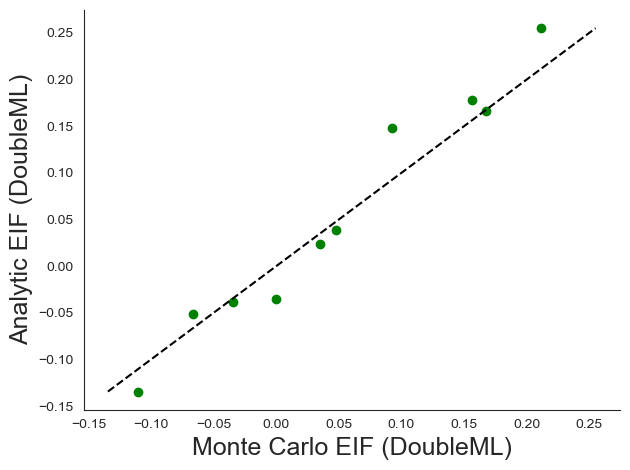

In [49]:
# Double ML
plt.scatter(
    estimates['monte_carlo_eif-double_ml'],
    estimates['analytic_eif-double_ml'],
    color='green',
)

# Plot y=x line for min and max values
min_val = min(
    estimates['monte_carlo_eif-double_ml'].min(),
    estimates['analytic_eif-double_ml'].min()
)
max_val = max(
    estimates['monte_carlo_eif-double_ml'].max(),
    estimates['analytic_eif-double_ml'].max()
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (DoubleML)", fontsize=18)
plt.ylabel("Analytic EIF (DoubleML)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/double_convergence_causal_glm.png')

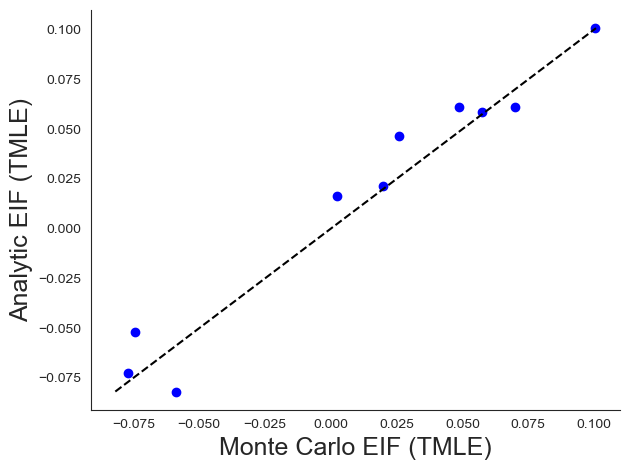

In [47]:
# TMLE
plt.scatter(
    estimates['monte_carlo_eif-tmle'],
    estimates['analytic_eif-tmle'],
    color='blue',
)

# Plot y=x line for min and max values
min_val = min(
    estimates['monte_carlo_eif-tmle'].min(),
    estimates['analytic_eif-tmle'].min()
)
max_val = max(
    estimates['monte_carlo_eif-tmle'].max(),
    estimates['analytic_eif-tmle'].max()
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (TMLE)", fontsize=18)
plt.ylabel("Analytic EIF (TMLE)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/tmle_convergence_causal_glm.png')

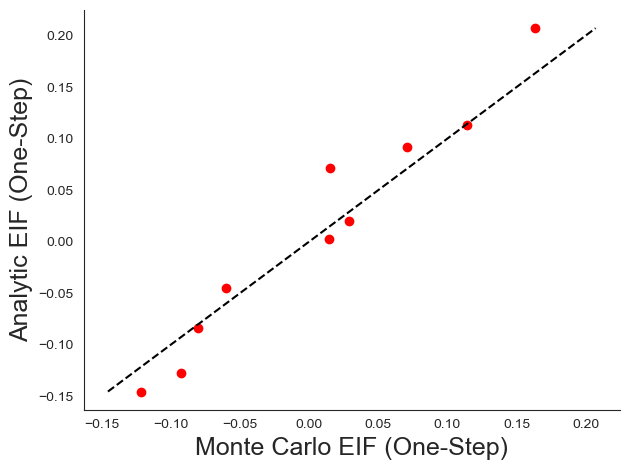

In [48]:
# One-step
plt.scatter(
    estimates['monte_carlo_eif-one_step'],
    estimates['analytic_eif-one_step'],
    color='red',
)

# Plot y=x line for min and max values
min_val = min(
    estimates['monte_carlo_eif-one_step'].min(),
    estimates['analytic_eif-one_step'].min()
)
max_val = max(
    estimates['monte_carlo_eif-one_step'].max(),
    estimates['analytic_eif-one_step'].max()
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (One-Step)", fontsize=18)
plt.ylabel("Analytic EIF (One-Step)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/one_step_convergence_causal_glm.png')

In [53]:
from pympler.tracker import SummaryTracker
tracker = SummaryTracker()


In [55]:
tracker.print_diff()

                                              types |   # objects |   total size
=================================================== | =========== | ============
                                               list |       38180 |      3.26 MB
                                                str |       39575 |      2.85 MB
                                                int |        7653 |    205.02 KB
                          pandas.core.series.Series |          24 |      7.35 KB
                                               type |          14 |      5.58 KB
          pandas.core.internals.blocks.NumericBlock |          24 |      2.06 KB
                                 wrapper_descriptor |          28 |      1.97 KB
                                              bytes |          14 |      1.71 KB
              pandas._libs.internals.BlockPlacement |          24 |      1.69 KB
                                              slice |          24 |      1.31 KB
                            

## References

Kennedy, Edward. "Towards optimal doubly robust estimation of heterogeneous causal effects", 2022. https://arxiv.org/abs/2004.14497.